In [2]:
import sys

sys.path.append("../../")
import pandas as pd
import torch
import numpy as np
import datetime

# that is something to
import os
from pprint import pprint
import math
import matplotlib.pyplot as plt

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 20)

plt.style.use("classic")
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.formatter.useoffset"] = False
plt.rcParams["axes.formatter.limits"] = [-1000000000, 1000000000]

In [3]:
from fredapi import Fred

fred = Fred(api_key="86962d243cd55992a83872d88f46e6de")

In [4]:
res = fred.search("us cpi")

size = 10
res = res.sort_values("popularity", ascending=False).head(size)
res = res.reset_index()[["title", "id", "frequency"]]
res

,title,id,frequency
0,Consumer Price Index for All Urban Consumers: ...,CPIAUCSL,Monthly
1,"Consumer Price Indices (CPIs, HICPs), COICOP 1...",USACPIENGMINMEI,Monthly
2,Consumer Price Index for All Urban Consumers: ...,CUUR0000SEFR,Monthly
3,Consumer Price Index for All Urban Consumers: ...,CUUSA211SEHA,Annual
4,Consumer Price Index for All Urban Consumers: ...,CUSR0000SAA2,Monthly
5,Research Consumer Price Index: Food and Beverages,CPIEBEV,Monthly
6,Consumer Price Index for All Urban Consumers: ...,CUSR0000SAE1,Monthly
7,"Sticky Price Consumer Price Index less Food, E...",CRESTKCPIXSLTRM157SFRBATL,Monthly
8,Consumer Price Index for All Urban Consumers: ...,CUUR0000SAS,Monthly
9,Consumer Price Index for All Urban Consumers: ...,CUUR0000SEHC01,Monthly


In [6]:
index = 2
series_name = res.iloc[index].id
original_dates = pd.Series(fred.get_series_vintage_dates(series_name))
original_dates = original_dates[original_dates.dt.year == 2024]
original_dates = original_dates.reset_index(drop=True)

<Axes: xlabel='original_date'>

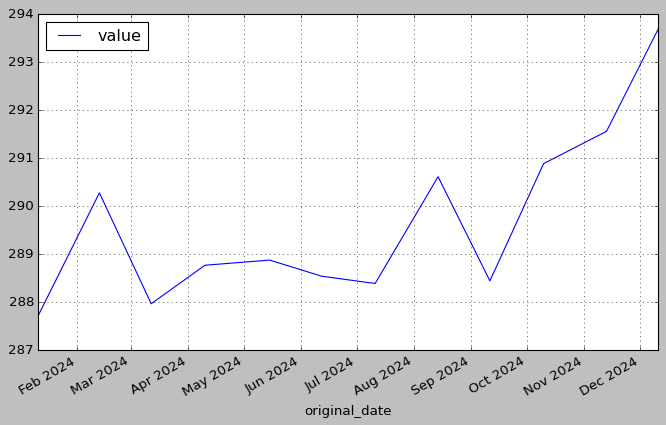

In [7]:
res = fred.get_series(series_name)
res = pd.DataFrame({"value": res[~res.isna()]})
res = res.reset_index()
res.columns = ["wrong_dt", "value"]
res = res[res.wrong_dt.dt.year >= original_dates.iloc[0].year]
res = res.reset_index(drop=True)
res = res.drop(columns=["wrong_dt"])

assert res.shape[0] == original_dates.shape[0]

res["original_date"] = pd.to_datetime(original_dates)
res = res.set_index("original_date")
res.plot()

### FX Street Calendar

In [13]:
currency = "USD"

if os.path.exists('/mnt/h'):
    base_path = '/mnt/h/data'
else:
    base_path = '../../phitech-data'

calendar = pd.read_csv(f"{base_path}/calendars/{currency}_calendar_2024.csv")
calendar

,event,start_date,country,impact,time_of_day,event_date
0,ADP Employment Change,12/04/2024 13:15:00,USD,HIGH,13:15:00,12/04/2024
1,ADP Employment Change,07/31/2024 12:15:00,USD,HIGH,12:15:00,07/31/2024
2,ADP Employment Change,01/04/2024 13:15:00,USD,HIGH,13:15:00,01/04/2024
3,ADP Employment Change,10/02/2024 12:15:00,USD,HIGH,12:15:00,10/02/2024
4,ADP Employment Change,07/03/2024 12:15:00,USD,HIGH,12:15:00,07/03/2024
...,...,...,...,...,...,...
303,S&P Global Services PMI,12/16/2024 14:45:00,USD,HIGH,14:45:00,12/16/2024
304,S&P Global Services PMI,06/21/2024 13:45:00,USD,HIGH,13:45:00,06/21/2024
305,S&P Global Services PMI,05/23/2024 13:45:00,USD,HIGH,13:45:00,05/23/2024
306,S&P Global Services PMI,01/24/2024 14:45:00,USD,HIGH,14:45:00,01/24/2024


In [16]:
# TODO: get a subset of these events and get the data from FX Street then manually enter it and save
#       the df so that we have a full view of what happened on the days.
calendar.event.unique().tolist()

['ADP Employment Change',
 'Average Hourly Earnings (MoM)',
 'Average Hourly Earnings (YoY)',
 'Bank Stress Test Info',
 'Consumer Price Index (MoM)',
 'Consumer Price Index (YoY)',
 'Consumer Price Index ex Food & Energy (MoM)',
 'Consumer Price Index ex Food & Energy (YoY)',
 'Core Personal Consumption Expenditures - Price Index (MoM)',
 'Core Personal Consumption Expenditures - Price Index (YoY)',
 'FOMC Economic Projections',
 'FOMC Minutes',
 'FOMC Press Conference',
 'Fed Interest Rate Decision',
 'Fed Monetary Policy Statement',
 "Fed's Chair Powell speech",
 "Fed's Chair Powell testifies",
 'Gross Domestic Product Annualized',
 'ISM Manufacturing PMI',
 'ISM Services PMI',
 'Interest Rate Projections - 1st year',
 'Interest Rate Projections - 2nd year',
 'Interest Rate Projections - 3rd year',
 'Interest Rate Projections - Current',
 'Interest Rate Projections - Longer',
 'Jackson Hole Symposium',
 'Michigan Consumer Sentiment Index',
 'Nonfarm Payrolls',
 'President Biden spee